In [ ]:
import torch
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt
torch.manual_seed(123)

In [ ]:
! unzip dataset.zip
! pip install umap-learn

Archive:  dataset.zip
replace dataset/real/data1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: umap-learn in /usr/local/lib/python3.10/dist-packages (0.5.5)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_intern

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat


class MatDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (string): Directory with all the .mat files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.all_files = [os.path.join(directory, 'real', file) for file in os.listdir(os.path.join(directory, 'real')) if file.endswith('.mat')]
        #self.fake_files = [os.path.join(directory, 'fake', file) for file in os.listdir(os.path.join(directory, 'fake')) if file.endswith('.mat')]
        #self.all_files = self.real_files + self.fake_files
        #self.labels = [1] * len(self.real_files) + [0] * len(self.fake_files)  # 1 for real, 0 for fake
        self.transform = transform

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_name = self.all_files[idx]
        mat = loadmat(file_name)
        array = mat['cropped_data']
        #else:
            # Use 'zero_data' key for fake files
            #array = mat['zero_data']

        #label = self.labels[idx]

        # Convert to 3 channels
        #data = np.repeat(array[:, :, np.newaxis], 3, axis=2)

        # Convert to PIL Image
        image = Image.fromarray(array)

        if self.transform:
            image = self.transform(image)

        return image


transform = transforms.Compose([
    transforms.Resize((64, 64)), # Resizing to 128x128
    transforms.ToTensor()
])

def print_dataset_summary(dataset):
    num_samples = len(dataset)
    #num_real = sum(1 for label in dataset.labels if label == 1)
    #num_fake = sum(1 for label in dataset.labels if label == 0)

    # Load a single sample to get its shape
    sample_data = dataset[0]
    data_shape = sample_data.shape

    print(f"Total number of samples: {num_samples}")
    #print(f"Number of real samples: {num_real}")
    #print(f"Number of fake samples: {num_fake}")
    print(f"Shape of a data sample: {data_shape}")

In [ ]:
# Usage Example
directory = './dataset/'
dataset = MatDataset(directory, transform)
# Example: Accessing the first item
image = dataset[0]
print(image.shape)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

torch.Size([1, 64, 64])


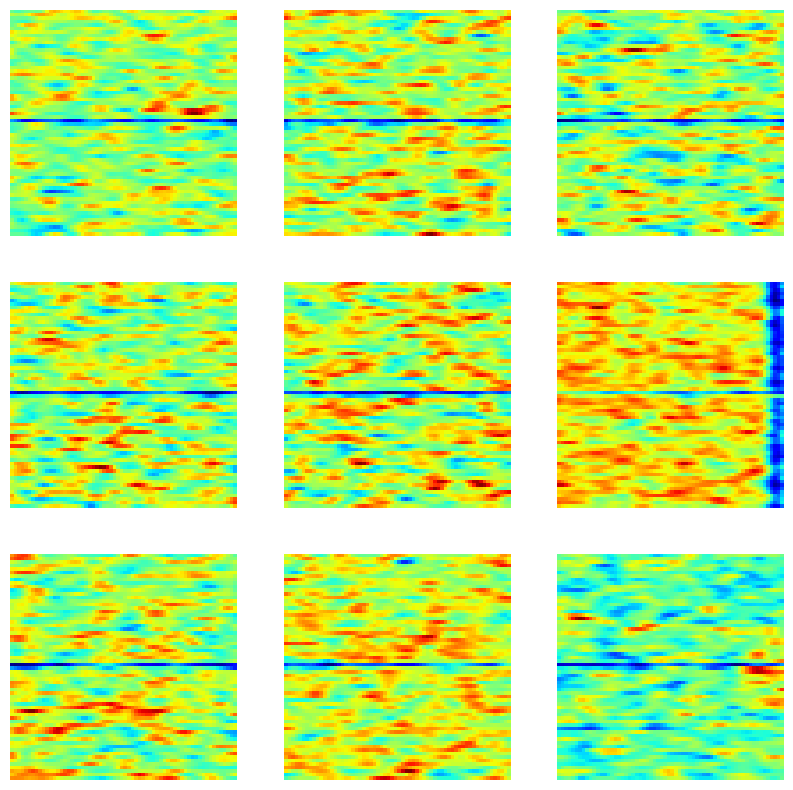

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



def grid_plot(data, rows, cols, figsize=(10, 10)):
    """
    Plot the data in a grid.

    Args:
    - data: A list or a torch tensor of images, each of size (1, 128, 128).
    - rows, cols: Number of rows and columns in the grid.
    - figsize: Size of the whole grid plot.
    """
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows, cols)

    for i in range(rows * cols):
        ax = plt.subplot(gs[i])
        ax.axis('off')

        # Check if data is a torch tensor and convert to numpy if needed
        if isinstance(data[i], torch.Tensor):
            img = data[i].numpy()
        else:
            img = data[i]

        # Squeeze in case the image has a singleton dimension at the beginning
        img = np.squeeze(img)

        # Apply the 'jet' colormap
        ax.imshow(img, cmap='jet')

    plt.show()

# Example usage:
# Assuming 'dataset' is your dataset object
# Let's create a list of 6 images from your dataset
for images in dataloader:
    # Only take the first 6 images for our grid
    grid_plot(images[:9], rows=3, cols=3)
    break  # Only process the first batch

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=1,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [ ]:
batch_size = 256
num_training_updates = 10000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []


for i in range(num_training_updates):
    data  = next(iter(dataloader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 2438520333.120
perplexity: 1.492

200 iterations
recon_error: 117511378.600
perplexity: 2.310

300 iterations
recon_error: 35103147.860
perplexity: 2.388

400 iterations
recon_error: 32154070.520
perplexity: 2.458

500 iterations
recon_error: 27287945.920
perplexity: 2.755

600 iterations
recon_error: 27478952.400
perplexity: 3.299

700 iterations
recon_error: 26095132.760
perplexity: 3.339

800 iterations
recon_error: 24868728.260
perplexity: 3.384

900 iterations
recon_error: 22718887.200
perplexity: 3.633

1000 iterations
recon_error: 20613120.380
perplexity: 4.614

1100 iterations
recon_error: 18681010.080
perplexity: 5.588

1200 iterations
recon_error: 17091220.270
perplexity: 6.485

1300 iterations
recon_error: 16334439.620
perplexity: 6.662

1400 iterations
recon_error: 15929357.780
perplexity: 6.367

1500 iterations
recon_error: 15486511.030
perplexity: 6.466

1600 iterations
recon_error: 14960655.940
perplexity: 6.742

1700 iterations
recon_error: 1

In [ ]:
from scipy.signal import savgol_filter
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

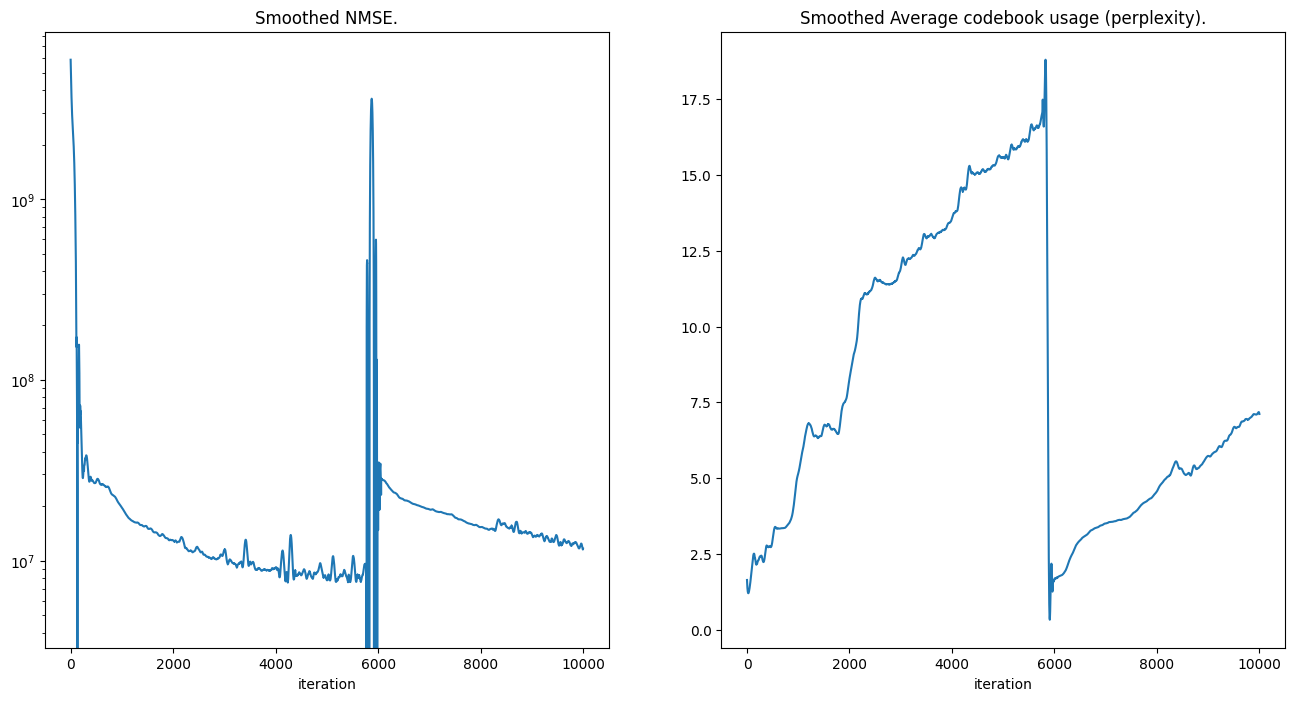

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [ ]:
model.eval()

valid_originals = next(iter(dataloader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

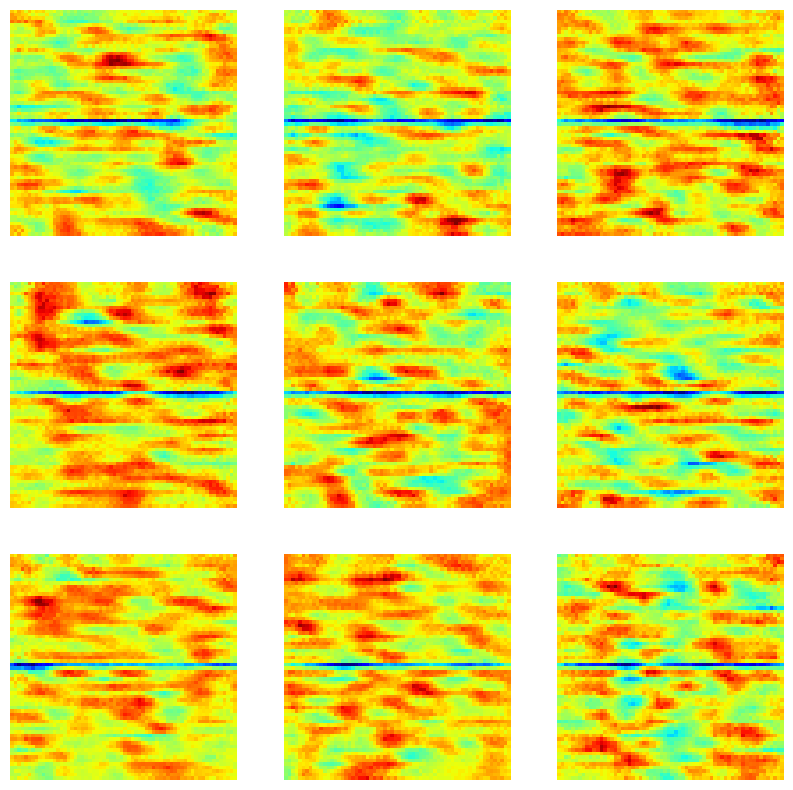

In [ ]:
grid_plot(valid_reconstructions.cpu().data[:9], rows=3, cols=3)

In [ ]:
random_indices = torch.randint(0, model._vq_vae._num_embeddings, (128, 16, 16), device=device)
encodings = F.one_hot(random_indices, num_classes=model._vq_vae._num_embeddings).float()
#encodings = torch.zeros([128, 16, 16, 512], device=device)
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight)
quantized = quantized.permute(0, 3, 1, 2)
valid_reconstructions = model._decoder(quantized)

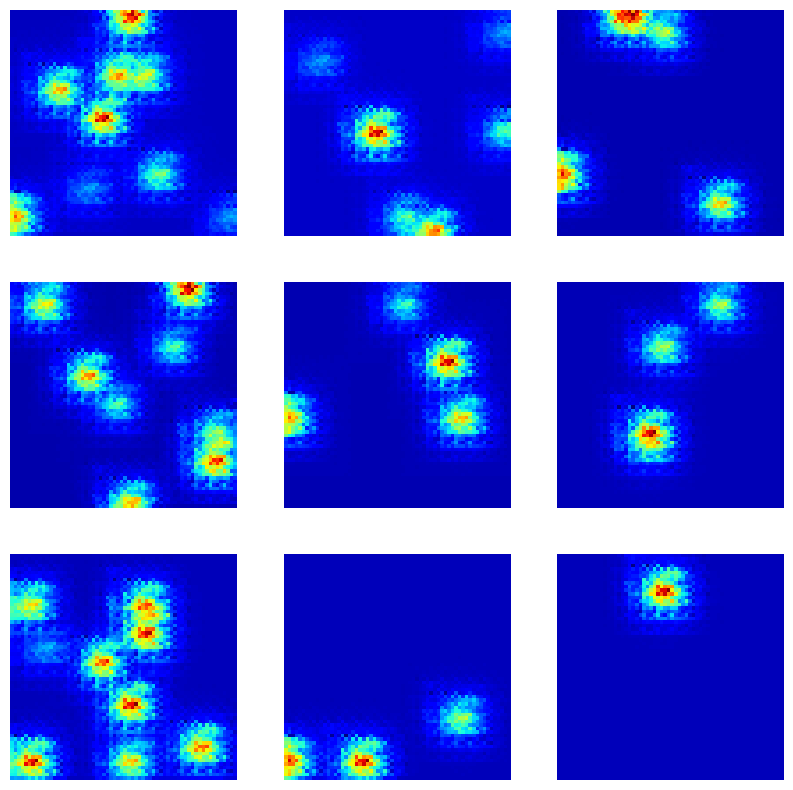

In [ ]:
grid_plot(valid_reconstructions.cpu().data[:9], rows=3, cols=3)

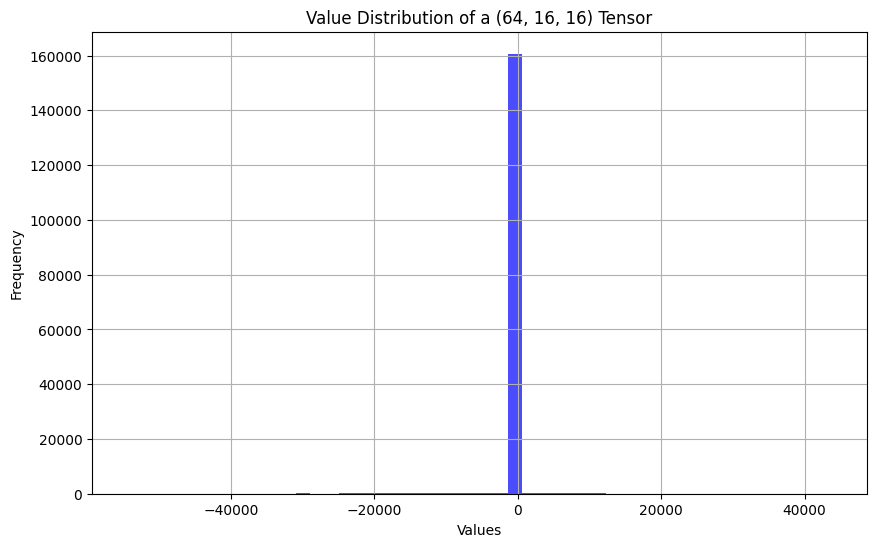

In [ ]:
# Flatten the tensor to a 1D array for plotting
values = quantized[0:10].flatten().cpu().detach().numpy()

# Plotting the histogram of the values
plt.figure(figsize=(10, 6))
plt.hist(values, bins=50, color='blue', alpha=0.7)
plt.title('Value Distribution of a (64, 16, 16) Tensor')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

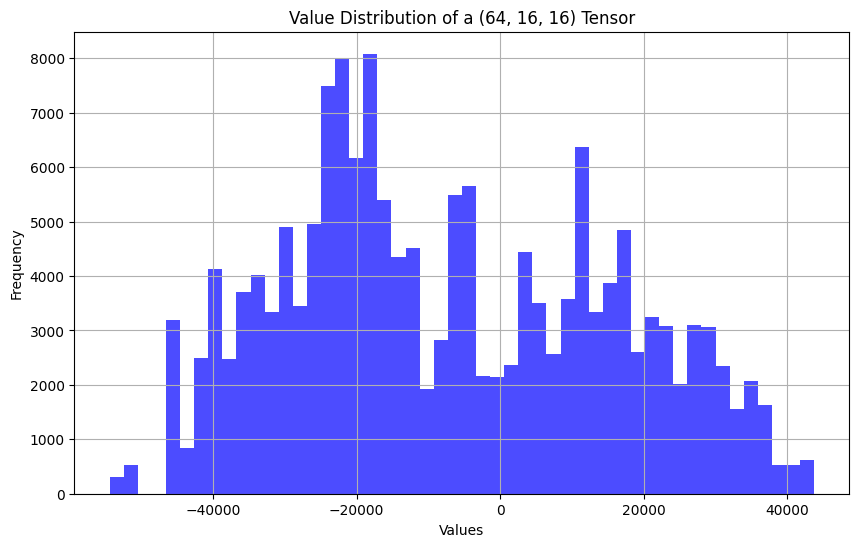

In [ ]:
# Flatten the tensor to a 1D array for plotting
values = valid_quantize[0:10].flatten().cpu().detach().numpy()

# Plotting the histogram of the values
plt.figure(figsize=(10, 6))
plt.hist(values, bins=50, color='blue', alpha=0.7)
plt.title('Value Distribution of a (64, 16, 16) Tensor')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()